In [6]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn import svm
import numpy as np
import matplotlib.pyplot as plt
import json
import csv
import pandas
import re
import pandas as pd
from pathlib import Path
from datetime import datetime
from pandas.io.json import json_normalize 
import matplotlib.pyplot as plt 

In [8]:
# now = datetime.now()
# s3_prefix = now.strftime("%Y_%m_%d_%H_%M_%S")
# print("s3_prefix =", s3_prefix)
s3_prefix = "2020_01_28_14_42_04"

In [52]:
%%bash -s "$s3_prefix"
python unique_urls.py output/$1_unique_urls.txt

In [5]:
%%bash -s "$s3_prefix"
export AWS_PROFILE="bmccarthy" && node src/populate-queue.js -i data/unique_urls.txt -p $1 -c 2

{ verbose: false,
  input: 'data/unique_urls.txt',
  count: '2',
  prefix: '2020_01_28_14_42_04' }
sending message http://ampa.pereiv.cat/recordatori-festa-cadires-i-ajuda/
sending message http://angleton.tx.us/calendar.aspx?view=list&year=2019&month=7&day=3
DONE! { count: 2 }


In [6]:
%%bash -s "$s3_prefix"
aws s3 cp s3://html-feature-extractor-worker-output/$1/ output/$1 --recursive --exclude "*" --include "*.json" --profile bmccarthy

download: s3://html-feature-extractor-worker-output/2020_01_28_14_42_04/ampa.pereiv.cat!recordatori-festa-cadires-i-ajuda_kcmGW4Tz.json to output/2020_01_28_14_42_04/ampa.pereiv.cat!recordatori-festa-cadires-i-ajuda_kcmGW4Tz.json
download: s3://html-feature-extractor-worker-output/2020_01_28_14_42_04/angleton.tx.us!calendar.aspx!day=3&month=7&view=list&year=2019_psaj0uOr.json to output/2020_01_28_14_42_04/angleton.tx.us!calendar.aspx!day=3&month=7&view=list&year=2019_psaj0uOr.json


In [9]:
pathlist = Path('output/' + s3_prefix).glob('**/*.json')
combined_df = {}

df_count = 0
for path in pathlist:
    path_in_str = str(path)
    with open(path_in_str) as f: 
        d = json.load(f) 
        df = json_normalize(d["elements"]) 
        print(path_in_str, df.shape)
        if df_count == 0:
            combined_df = df
        else:
            combined_df = combined_df.append(df)
        df_count = df_count + 1

print('total size of raw data', combined_df.shape)

output/2020_01_28_14_42_04/ampa.pereiv.cat!recordatori-festa-cadires-i-ajuda_kcmGW4Tz.json (551, 20)
output/2020_01_28_14_42_04/angleton.tx.us!calendar.aspx!day=3&month=7&view=list&year=2019_psaj0uOr.json (1235, 20)
total size of raw data (1786, 20)


In [11]:
# Preprocess data - remove uncessary columns and make all columns numbers
le = preprocessing.LabelEncoder()
X = combined_df.copy()
X["fontSize"] = X["fontSize"].apply(lambda x : re.sub("[^0-9.]", "", x)).astype(float)
X["itemType"] = X["itemType"].apply(lambda x : 1. if x=="http://schema.org/Event" else 0.)
X["tagName"] = le.fit_transform(X["tagName"])

X = X.drop(labels=["color", "elementId", "classList", "textContent", "font", "fontStyle", "backgroundColor", "background", "backgroundImage", "itemProp", "opacity", "lineHeight", "fontWeight"], axis=1)

# Take the dependent variable out, the one we are trying to predict
y = X.pop("itemType").values

# Split into train and test sets
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size = 0.1, random_state = 42)

gnb = GaussianNB()
pred = gnb.fit(train_x, train_y).predict(test_x)
print("Naive-Bayes accuracy : ",accuracy_score(test_y, pred, normalize = True))

svc_model = LinearSVC(random_state=0)
pred = svc_model.fit(train_x, train_y).predict(test_x)
print("LinearSVC accuracy : ",accuracy_score(test_y, pred, normalize = True))



Naive-Bayes accuracy :  0.9497206703910615
LinearSVC accuracy :  1.0
/home/billtrust.local/bmccarthy/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [ ]:
# ml_pipe.score(np.zeros((1428, 7)), np.zeros(1428))

# updated_df.fontSize = updated_df.fontSize.apply(lambda x : re.sub("[^0-9.]", "", x))
# updated_df.lineHeight = updated_df.lineHeight.apply(lambda x : re.sub("[^0-9]", "", x))
# updated_df.itemType = updated_df.itemType.apply(lambda x : "http://schema.org/Event" == x)

# y = updated_df.pop("itemType").values
# X = updated_df.drop(labels=["color", "elementId", "tagName", "classList", "textContent", "font", "fontStyle", "backgroundColor", "background", "backgroundImage", "itemProp", "opacity"], axis=1)

# xTrain, xTest, yTrain, yTest = train_test_split(X, y, test_size = 0.2, random_state = 42)

# print("Whole set:", X.shape, y.shape)
# print("Training set:", xTrain.shape, yTrain.shape)
# print("Testing set:", xTest.shape, yTest.shape)

# print(xTrain.head(100))

# print(combined_df.describe())

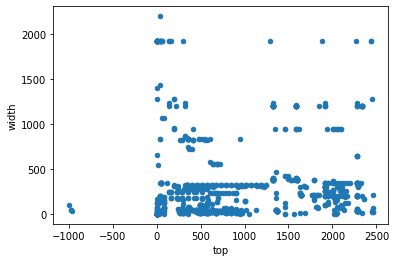

In [30]:
combined_df.plot.scatter(x='top', y='width')

In [54]:
print(xTrain.shape)
ml_pipe = Pipeline([('ridge', Ridge())])
ml_pipe.fit(np.zeros((1428, 7)), np.zeros(1428))
ml_pipe.score(np.zeros((1428, 7)), np.zeros(1428))

(1428, 7)


1.0